In [1]:
%matplotlib notebook
%load_ext autoreload

In [2]:
from matplotlib import pyplot as plt
from main import *
from tqdm import tqdm

<IPython.core.display.Javascript object>


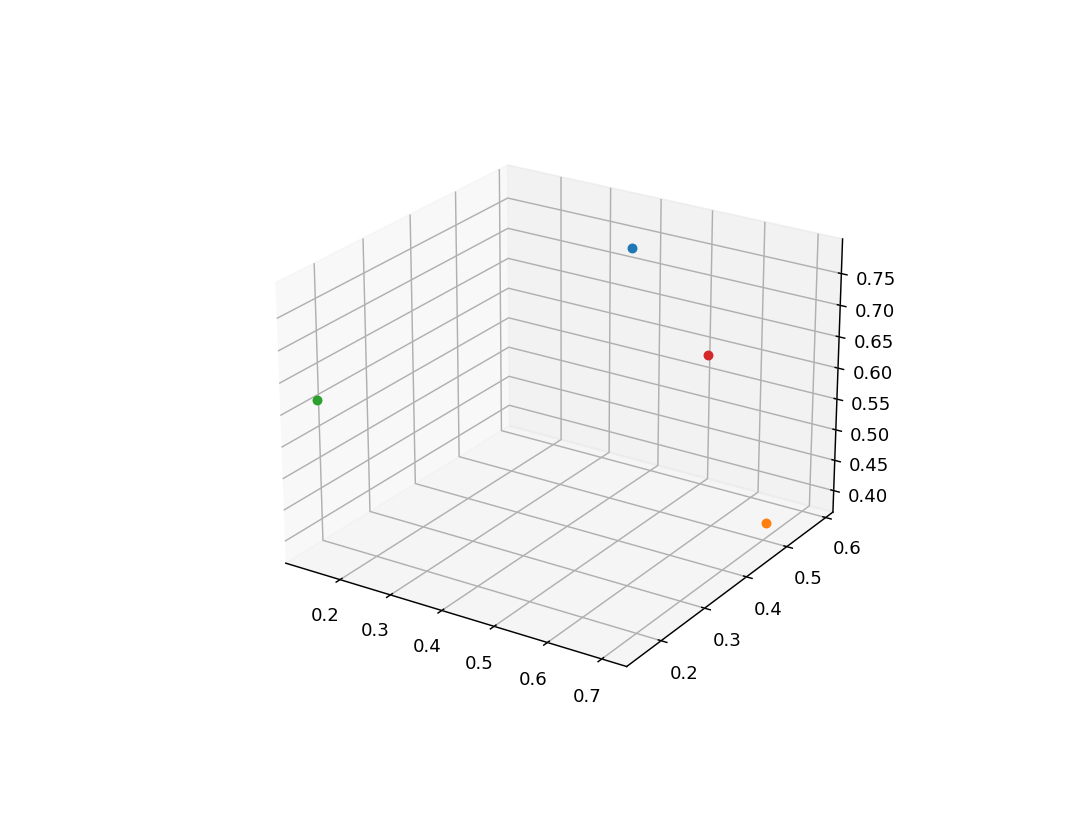



Received SIGINT. Closing simulation
Last Values:
P0 - Current Position (0.4363; 0.5056; 0.7761)
P1 - Current Position (0.7036; 0.5031; 0.3923)
P2 - Current Position (0.1319; 0.1549; 0.6188)
P3 - Current Position (0.5209; 0.5875; 0.5874)


In [3]:
# arr = create_random(len(bodies))
bodies = tuple(get_random_bodies(4))
arr = np.array(tuple((b.position, b.velocity) for b in bodies))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

try:
    while True:
        calc_next_step(arr, bodies)
        ax.cla()
        for (xs, ys, zs) in map(lambda x: x[0], arr[:, [0]]):
            ax.scatter(xs, ys, zs, marker='o')
        fig.canvas.draw()
        fig.show()
except KeyboardInterrupt as e:
    print(); print()
    print("Received SIGINT. Closing simulation")
    print("Last Values:")
    pretty_print_coordinates(bodies, arr)